In [2]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load each
datasets = {}
for hour in range(24):
    datasets[hour] = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

datasets_train = {hour: datasets[hour][(datasets[hour]['DATE'] >= '2014-01-01') & (datasets[hour]['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}
datasets_test = {hour: datasets[hour][datasets[hour]['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}

y_train = {hour: datasets_train[hour][:, 0].reshape(-1, 1) for hour in range(24)}
y_test = {hour: datasets_test[hour][:, 0].reshape(-1, 1) for hour in range(24)}

weather_train = {hour: datasets_train[hour][:, 1:-1] for hour in range(24)}
weather_test = {hour: datasets_test[hour][:, 1:-1] for hour in range(24)}



In [22]:
X = weather_train
X[0]

array([[ 0. ,  0. ,  0. , ...,  3. ,  7.2,  5.4],
       [ 0. ,  0. ,  0. , ...,  3.4,  6.2,  1.9],
       [ 0. ,  0. ,  0. , ...,  2.7,  6.7,  5.1],
       ...,
       [ 0. ,  0. ,  0. , ...,  2.4,  8.2, 12.7],
       [ 0. ,  0. ,  0. , ...,  2.9,  7.2,  7.6],
       [ 0. ,  0. ,  0. , ...,  4. ,  7.7,  8.7]])

In [5]:
def PCA_dimreduc(training_data, test_data, exp_var_pct):

    # Compute mean (bias) of training data
    PCA_bias = np.mean(training_data, axis=0)

    # Find number of loadings mathcing the level of explained variance
    pca = PCA()
    pca.fit(training_data)
    components = pca.components_
    eigvals_i = (pca.singular_values_) ** 2 # eigenvalues equals the squared singular values
    explained_variance_cumsum = np.array(list(enumerate((np.cumsum(eigvals_i) / np.sum(eigvals_i)), start=1))) # computing cummulative explained variancec with correct index
    K_loadings = min(np.where(explained_variance_cumsum[:,1] >= exp_var_pct)[0]) + 1 # number of components to explain X pct. variance

    # Extract first K principal components (PCA loadings) necessary to match the chosen level of explained variance
    PCA_loadings = components[0:K_loadings, :].T

    # Compute dimensinality reduced data by projecting the centered test_data onto the first K principal components
    data_dimreduc = (test_data - PCA_bias) @ PCA_loadings

    return data_dimreduc, PCA_loadings, PCA_bias, K_loadings, explained_variance_cumsum

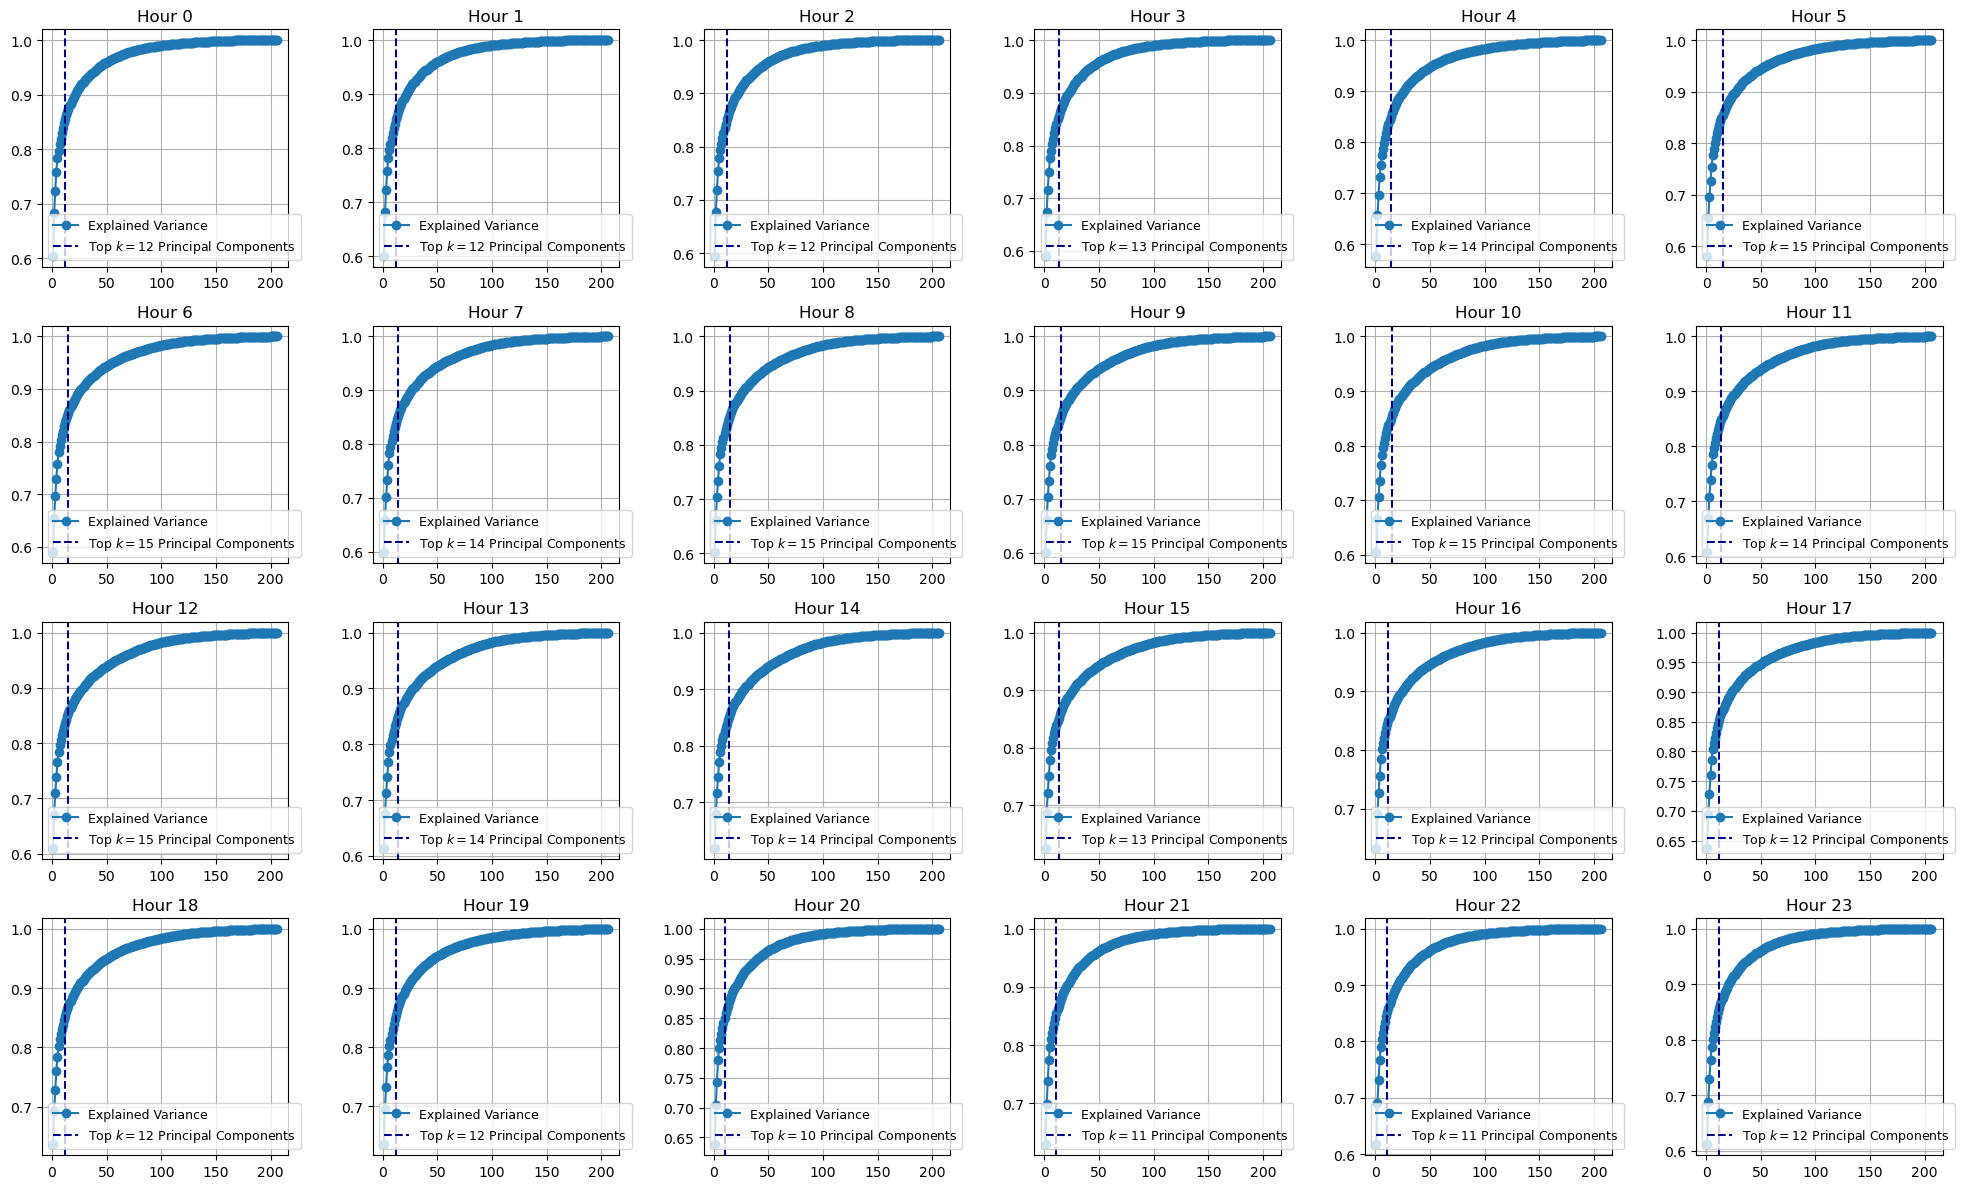

In [43]:

class DimReduc:
    def __init__(self, pct):

        self.pct = pct
        self.k = None
        self.Z = None
        self.plot_var = None
    
    def fit(self, X):
        pca = PCA().fit(X)
        eigvals_i = (pca.singular_values_) ** 2
        explained_var = np.array(list(enumerate((np.cumsum(eigvals_i) / np.sum(eigvals_i)), start=1)))
        
        
        k = min(np.where(explained_var[:,1] >= self.pct)[0]) + 1
        self.k = k
        self.plot_var = explained_var

def plot_explained_variance(X, pct):
    fig, axs = plt.subplots(4, 6, figsize=(20, 12))
    axs = axs.flatten()
    for i in range(24):
        model = DimReduc(pct=pct)
        model.fit(X[i])
        plot = model.plot_var
        
        ax = axs[i]
        ax.plot(plot[:, 0], plot[:, 1], label='Explained Variance', marker='o')
        ax.axvline(x=model.k, color='navy', linestyle='--', label=f'Top $k = {model.k}$ Principal Components')
        ax.legend(prop={'size': 9})
        ax.grid(True)
        ax.set_title(f'Hour {i}')
    
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

plot_explained_variance(X, pct = 0.85)